## Visualizing Graphs

A (directed) graph $G = (V, E)$ consists of a set of vertices (or nodes) $V$, and a set of edges $E \subseteq V \times V$.

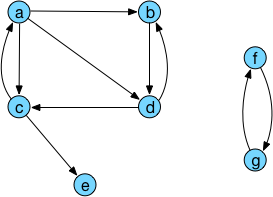

An example of a graph with $V = \{a, b, c, d, e, f, g\}$ and $E = \{(a, b), (a, c), (a,d), (b,d), (c,a), (c, e), (d, b), (d, c), (f, g), (g, f)\}$.

How should we represent a graph?  A general principle of software development -- really, of life -- is: failing special reasons, always go for the simplest solution.
So our first attempt consists in storing a graph exactly according to its definition: as a set of vertices and a set of edges.

In [ ]:
class Graph(object):

    def __init__(self, vertices=None, edges=None):
        # We use set below, just in case somebody passes a list to the initializer.
        self.vertices = set(vertices or [])
        self.edges = set(edges or [])


In [ ]:
g = Graph(vertices={'a', 'b', 'c', 'd', 'e', 'f', 'g'},
          edges={('a', 'b'), ('a', 'c'), ('a', 'd'), ('b', 'd'),
                 ('c', 'a'), ('c', 'e'), ('d', 'b'), ('d', 'c'),
                 ('f', 'g'), ('g', 'f')})


Great, but, how do we display graphs?  And what can we do with them?  

Let's first of all add a method .show() that will enable us to look at a graph; this uses the library [networkx](https://networkx.github.io/).

In [ ]:
import networkx as nx # Library for displaying graphs.

class Graph(object):

    def __init__(self, vertices=None, edges=None):
        # We use set below, just in case somebody passes a list to the initializer.
        self.vertices = set(vertices or [])
        self.edges = set(edges or [])

    def show(self):
        g = nx.DiGraph()
        g.add_nodes_from(self.vertices)
        g.add_edges_from(self.edges)
        nx.draw(g, with_labels=True)


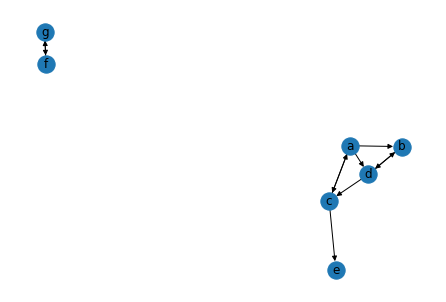

In [ ]:
g = Graph(vertices={'a', 'b', 'c', 'd', 'e', 'f', 'g'},
          edges={('a', 'b'), ('a', 'c'), ('a', 'd'), ('b', 'd'),
                 ('c', 'a'), ('c', 'e'), ('d', 'b'), ('d', 'c'),
                 ('f', 'g'), ('g', 'f')})
g.show()


Ok, this is not nearly as pretty as what we generated by hand, but it will have to do.

## One-Step Reachability and Graph Representations

What are conceivable operations on graphs?  There are some basic ones, such as adding a vertex and adding an edge.  These are easily taken care of.

In [ ]:
import networkx as nx # Library for displaying graphs.

class Graph(object):

    def __init__(self, vertices=None, edges=None):
        # We use set below, just in case somebody passes a list to the initializer.
        self.vertices = set(vertices or [])
        self.edges = set(edges or [])

    def show(self):
        g = nx.DiGraph()
        g.add_nodes_from(self.vertices)
        g.add_edges_from(self.edges)
        nx.draw(g, with_labels=True)

    def add_vertex(self, v):
        self.vertices.add(v)

    def add_edge(self, e):
        self.edges.add(e)


Further, a graph represents a set of connections between vertices, so a very elementary question to ask is the following: if we are at vertex $v$, can we get to another vertex $u$ by following one or more edges?

As a first step towards the solution, we want to compute the set of vertices reachable from $v$ in one step, by following one edge; we call these vertices the _successors_ of $v$.

Writing a function g.successors(u) that returns the set of successors of $u$ is simple enough.  Note that the code directly mimicks the mathematical definition:

$$
\mathit{Successors}(u) = \{v \in V \mid (u, v) \in E\} \; .
$$

In [ ]:
import networkx as nx # Library for displaying graphs.

class Graph(object):

    def __init__(self, vertices=None, edges=None):
        # We use set below, just in case somebody passes a list to the initializer.
        self.vertices = set(vertices or [])
        self.edges = set(edges or [])

    def show(self):
        g = nx.DiGraph()
        g.add_nodes_from(self.vertices)
        g.add_edges_from(self.edges)
        nx.draw(g, with_labels=True)

    def add_vertex(self, v):
        self.vertices.add(v)

    def add_edge(self, e):
        self.edges.add(e)

    def successors(self, u):
        """Returns the set of successors of vertex u"""
        return {v for v in self.vertices if (u, v) in self.edges}


In [ ]:
g = Graph(vertices={'a', 'b', 'c', 'd', 'e', 'f', 'g'},
          edges={('a', 'b'), ('a', 'c'), ('a', 'd'), ('b', 'd'),
                 ('c', 'a'), ('c', 'e'), ('d', 'b'), ('d', 'c'),
                 ('f', 'g'), ('g', 'f')})
g.successors('a')


{'b', 'c', 'd'}

But there's a rub.  The method successors, as written, requires us to loop over the whole set of vertices.  Because self.edges is a set, represented as a hash table, once we have a pair (u, v), checking

    (v, u) in self.edges
    
is efficient.  But typically, graphs have a locality structure, so that each node is connected only to a small subset of the total vertices; having to loop over all vertices to find the successors of a vertex is a great waste.
It is as if I asked you to what places you can get from San Francisco with a direct flight, and to answer, you started to rattle off all of the world's cities, from Aachen, Aalborg, Aarhus, ..., all the way to Zürich, Zuwarah, Zwolle, and for each city you checked if there's a flight from San Francisco to that city!  Clearly not the best method.

Given that our main use for graphs is to answer reachability-type questions, a better idea is to store the edges via a dictionary that associates with each vertex the set of successors of the vertex.  The vertices will simply be the keys of the dictionary.


In [ ]:
import networkx as nx # Library for displaying graphs.

class Graph(object):

    def __init__(self, vertices=None, edges=None):
        self.s = {u: set() for u in vertices or []}
        for u, v in (edges or []):
            self.add_edge((u, v))

    def show(self):
        g = nx.DiGraph()
        g.add_nodes_from(self.s.keys())
        g.add_edges_from([(u, v) for u in self.s for v in self.s[u]])
        nx.draw(g, with_labels=True)

    def add_vertex(self, v):
        if v not in self.s:
            self.s[v] = set()

    def add_edge(self, e):
        u, v = e
        self.add_vertex(u)
        self.add_vertex(v)
        self.s[u].add(v)

    @property
    def vertices(self):
        return set(self.s.keys())

    def successors(self, u):
        """Returns the set of successors of vertex u"""
        return self.s[u]


{'d', 'c', 'b'}


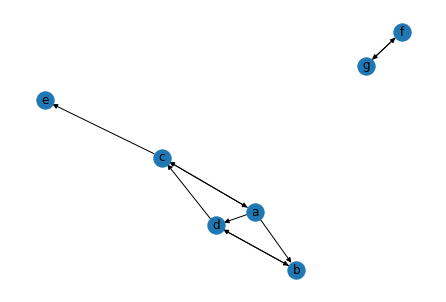

In [ ]:
g = Graph(vertices={'a', 'b', 'c', 'd', 'e', 'f', 'g'},
          edges={('a', 'b'), ('a', 'c'), ('a', 'd'), ('b', 'd'),
                 ('c', 'a'), ('c', 'e'), ('d', 'b'), ('d', 'c'),
                 ('f', 'g'), ('g', 'f')})
g.show()
print(g.successors('a'))


## Graph Reachability

We now come to one of the fundamental graph algorithms, in fact, perhaps _the_ most fundamental algorithm for graphs: computing the set of vertices reachable from a given starting vertex.  Exploring what is reachable from a graph vertex is a truly basic task, and variations on the algorithm can be used to answer related questions, such as whether a vertex is reachable from a given starting vertex.

The algorithm keeps two sets of vertices:

* The set of _open_ vertices: these are the vertices that are known to be reachable, and whose successors have not yet been explored.
* The set of _closed_ vertices: these are the vertices that are known to be reachable, and whose successors we have already explored.

Intially, the set of open vertices contains only the starting vertex, and the set of closed vertices is empty, as we have completed no exploration.
Repeatedly, we pick an open vertex, we move it to the closed set, and we put all its successor vertices -- except those that are closed already -- in the open set.   The algorithm continues until there are no more open vertices; at that point, the set of reachable vertices is equal to the closed vertices.  

If there is _one_ graph algorithm that you must learn by heart, and that you should be able to write even when you hang upside down from monkeybars, this is it.

Let us write the algorithm as a function first.


In [ ]:
def reachable(g, v):
    """Given a graph g, and a starting vertex v, returns the set of states
    reachable from v in g."""
    vopen = {v}
    vclosed = set()
    while len(vopen) > 0:
        u = vopen.pop()
        vclosed.add(u)
        vopen.update(g.successors(u) - vclosed)
    return vclosed


In [ ]:
print(reachable(g, 'a'))
print(reachable(g, 'g'))


{'d', 'e', 'c', 'b', 'a'}
{'f', 'g'}


To visualize the algorithm, let us write a version where at each iteration, open vertices are drawn in red and closed ones in green

In [ ]:
def reachable(g, v):
    """Given a graph g, and a starting vertex v, returns the set of states
    reachable from v in g."""
    vopen = {v}
    vclosed = set()
    while len(vopen) > 0:
        u = vopen.pop()
        vclosed.add(u)
        vopen.update(g.successors(u) - vclosed)
    return vclosed


In [ ]:
reachable(g, 'a')


{'a', 'b', 'c', 'd', 'e'}

## Breadth-First and Depth-First Search

### Breadth First

In **breadth-first** search, we explore in concentric circles emanating from the starting point: first all vertices at distance 1, then all vertices at distance 2, and so on.  In general, we explore all vertices at distance $\leq n$ before we explore vertices at distances $>n$.

To implement breadth-first search, we store the open vertices `vopen` as a list rather than a set.  We then explore vertices in the order they have been added to `vopen`: this ensures that vertices closer to the search origin are explored earlier than farther-away vertices.

The difference in code between reachability search, and its specialized breadth-first version, is minimal.


In [ ]:
def breath_first(g, v):
    """Given a graph g, and a starting vertex v, returns the set of states
    reachable from v in g."""
    # vopen is a FIFO: first in, first out. Like a normal queue.
    # we add elements from the end, and pop them from the beginning.
    vopen = [v]
    vclosed = set()
    while len(vopen) > 0:
        u = vopen.pop(0) # Pop from the beginning
        vclosed.add(u)
        # vopen.update(g.successors(u) - vclosed)
        for w in g.successors(u) - vclosed:
            if w not in vopen:
                vopen.append(w) # Add to the end
    return vclosed


In [ ]:
gg = Graph(vertices={},
           edges={('a', 'b'), ('b', 'c'), ('c', 'd'),
                  ('a', 'u'), ('u', 'v'), ('v', 'w'), ('u', 'z')})


In [ ]:
breath_first(gg, 'a')


{'a', 'b', 'c', 'd', 'u', 'v', 'w', 'z'}

We see that we explore $b$ and $u$ before any of their successors are explored, and similarly, we explore $z$, $v$, and $c$ before $d$ or $w$.

### Depth-First Search

In **depth-first** search, we follow a path as long as possible, and only when we come to an end do we explore other nodes.  In depth-first search, the most recent visited vertex, the one added last to the list of open vertices, is the one that will be explored first.

The difference in code from breadth-first search is minimal.  In breadth-first search, the vertex to be explored next is the _oldest_ among the open ones:

        u = vopen.pop(0)

In depth-first search, it will be the _newest_ among the open ones:

        u = vopen.pop()

That's the whole difference.

In [ ]:
def depth_first(g, v):
    """Given a graph g, and a starting vertex v, returns the set of states
    reachable from v in g."""
    # vopen is a stack / LIFO: last in, first out. Like a stack.
    # we add elements from the end, and pop them from the end.
    vopen = [v]
    vclosed = set()
    while len(vopen) > 0:
        u = vopen.pop() # THIS is the difference: there is no 0 in the parentheses.
        vclosed.add(u)
        # vopen.update(g.successors(u) - vclosed)
        for w in g.successors(u) - vclosed:
            if w not in vopen:
                vopen.append(w)
    return vclosed


In [ ]:
depth_first(gg, 'a')


{'a', 'b', 'c', 'd', 'u', 'v', 'w', 'z'}

We see how in depth-first search we explore completely one side of the successors of $a$, consisting of $u, v, w, z$, before exploring the other side $b, c, d$.

## Returning the edges

In our latest implementation, we do not have direct access to the edges of the graph.  In other words, for a graph g, we cannot do:

    for (u, v) in g.edges:
        ...

We ask you to write an iterator over edges, to make the above code work.  The iterator should yield the edges of the graph, one by one.

In [ ]:
### An iterator for the set of edges

def graph_edges(self):
    """Yields the edges of the graph, one by one.  Each edge is yielded as a
    pair of vertices (source, destination). """
    for src in self.vertices:
      v = set(self.s[src])
      for dst in v:
        yield(src, dst)



Graph.edges = property(graph_edges)


Here are some tests.

In [ ]:
### simple tests

e = [(1, 2), (1, 3), (2, 3)]
g = Graph(vertices=[1, 2, 3], edges=e)
assert set(g.edges) == set(e)

import types
assert isinstance(g.edges, types.GeneratorType)


Here are some randomized test.

In [ ]:
### random tests

import random

for _ in range(10):
    num_vertices = random.randint(4, 10)
    num_edges = random.randint(1, num_vertices * num_vertices)
    vertices = random.sample(range(0, 1000), num_vertices)
    edges = {(random.choice(vertices), random.choice(vertices)) for _ in range(num_edges)}
    g = Graph(vertices=vertices, edges=edges)
    assert set(g.edges) == edges



## Is a graph a tree?

A tree is a graph $(V, E)$ with two special properties:

* Every vertex has at most one incoming edge.
* Either there are no vertices, or there is a vertex with no incoming edges, called the _root_, from which all other vertices are reachable.

If the second property does not hold, incidentally, the graph is called a _forest._

Write an `is_tree` function such that `is_tree(g)` returns True if the graph `g` is a tree, False otherwise.

In [ ]:
 ### Implementation of tree test

def is_tree(g):
    """Returns True iff the graph is a tree."""

    setss = set()

    for x,y in g.edges:
      setss.add(x)
    return False if len(setss) > 1 else True


In [ ]:
 ### Tests for `is_tree`

g = Graph(vertices=[1, 2, 3], edges=[(1, 2), (1, 3)])
assert is_tree(g)
g = Graph(vertices=[1, 2, 3], edges=[(1, 2), (2, 3), (1, 3)])
assert not is_tree(g)
g = Graph(vertices=[1, 2, 3], edges=[(1, 3), (2, 3)])
assert not is_tree(g)



In [ ]:
### More tests for `is_tree`

g = Graph()
assert is_tree(g)



## Reachability using either of two graphs

In this problem, you are given _two_ graphs `g1`, `g2`, that share the same set of vertices.
You have to write a function `can_reach(v, g1, g2, w)`, which returns `True` iff you can go from vertex `v` to vertex `w` using either edges of `g1` or `g2`.
Note that to go from `v` to `w`, you can use one or more edges from `g1` and one or more edges of `g2`, mixed in any way you like.  To solve the problem, you have to modify the reachability algorithms so that edges from either graph can be used.

_Hint:_ Modify the reachability algorithm.


In [ ]:
def can_reach(v, g1, g2, w):
    """Given two graphs g1, g2 that share the same vertices, and two verteces v, w,
    returns True if you can go from v to w using edges of either g1 or g2 (mixed any
    way you want) and False otherwise."""
    g1E = []
    for e in g1.edges:
      g1E.append(e)
    g2E = []
    for e in g2.edges:
      g2E.append(e)
    g = Graph(vertices = list(g1.vertices), edges =(list(set(g1E).union(set(g2E)))))
    c = reachable(g,v)
    return True if w in c else False




In [ ]:
### simple tests for can_reach

vertices = {1, 2, 3, 4, 5, 6, 7}
g1 = Graph(vertices=vertices, edges=[(1, 2), (3, 4)])
g2 = Graph(vertices=vertices, edges=[(2, 3), (4, 5), (6, 7)])
assert can_reach(1, g1, g2, 2)
assert can_reach(1, g1, g2, 3)
assert can_reach(1, g1, g2, 4)
assert can_reach(1, g1, g2, 5)
assert not can_reach(1, g1, g2, 6)
assert not can_reach(1, g1, g2, 7)


In [ ]:
### more advanced tests for can_reach

vertices = set(range(100))
# g1 edges go from n to 2n, g2 edges go from n to 3n.
g1 = Graph(vertices=vertices, edges=[(n, 2 * n) for n in range(100) if 2 * n < 100])
g2 = Graph(vertices=vertices, edges=[(n, 3 * n) for n in range(100) if 3 * n < 100])
assert can_reach(1, g1, g2, 6)
assert can_reach(1, g1, g2, 24)
assert can_reach(1, g1, g2, 32)
assert can_reach(1, g1, g2, 9)
assert not can_reach(1, g1, g2, 15)
assert not can_reach(1, g1, g2, 60)
assert can_reach(5, g1, g2, 15)
assert can_reach(5, g1, g2, 30)

